<h1 style="font-size:30px;">The Data</h1>

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
from tensorflow.keras.datasets import mnist

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

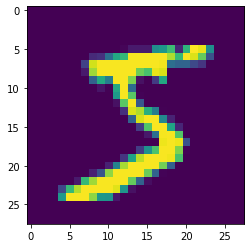

In [48]:
plt.imshow(x_train[0])

In [49]:
y_train[0] #so as we see above and below, the image shows "5".

5

## Reshape and Rescale Images for DCGAN

Generator will use tanh activation function for the last layer, so we want to reshape x_train to be within -1 to 1 limits.

In [50]:
x_train = x_train / 255

In [51]:
x_train = x_train.reshape(-1, 28, 28, 1) * 2 - 1

In [52]:
# x_train.min()

In [53]:
# x_train.max()


## Filtering out the Data for Faster Training on Smaller Dataset

In [54]:
only_zeros = x_train[y_train==0] #images that only show "0"

In [55]:
only_zeros.shape

(5923, 28, 28, 1)

In [56]:
x_train.shape

(60000, 28, 28, 1)

In [57]:
#as we can see above, there are fewer images in "only_zeros", that can help reduce the length of the data we work with.

In [58]:
# plt.imshow(only_zeros[10])
# plt.imshow(only_zeros[13])

<h1 style="font-size:30px;">The Model</h1>


<h1 style="font-size:20px;">1) generator</h1>

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose

In [60]:
#The GAN's "generator" is very much like Autoencoder's "decoder".
coding_size = 100 #so: 28*28=784 so: 784 --> 150 --> ? --> 150 --> 784 so: ?=100

generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[coding_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))



<h1 style="font-size:20px;">2) discriminator</h1>

In [61]:
#A simple model without using CNN:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')


<h1 style="font-size:20px;">3) GAN</h1>

In [62]:
GAN = Sequential([generator, discriminator])

In [63]:
discriminator.trainable = False #the "discriminator" should not be trained.

In [64]:
GAN.compile(loss = "binary_crossentropy", optimizer = 'adam')


<h1 style="font-size:20px;">create batches</h1>

In [65]:
batch_size = 32

In [66]:
my_dataset = only_zeros #or: x_train

In [67]:
#like what we do in NLP:

dataset = tf.data.Dataset.from_tensor_slices(my_dataset).shuffle(buffer_size = 1000) #buffer_size = 1000: is just a limit

In [68]:
# type(dataset)

In [69]:
dataset = dataset.batch(batch_size = batch_size, drop_remainder = True).prefetch(1)

In [70]:
# len(my_dataset) / batch_size #so "drop_remainder = True" will drop the remaider .09375

In [71]:
epochs = 20 #if at the end, the image by the generator was too noisy, then assign a larger number like 10 to the "epochs".

In [72]:
# GAN.layers
# GAN.layers[0].layers

# GAN.layers[0].summary() #generator
# GAN.layers[1].summary() #discriminator

In [73]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i = i + 1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_dataset)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            
    

Currently on Epoch 1
	Currently on batch number 100 of 185
Currently on Epoch 2
	Currently on batch number 100 of 185
Currently on Epoch 3
	Currently on batch number 100 of 185
Currently on Epoch 4
	Currently on batch number 100 of 185
Currently on Epoch 5
	Currently on batch number 100 of 185
Currently on Epoch 6
	Currently on batch number 100 of 185
Currently on Epoch 7
	Currently on batch number 100 of 185
Currently on Epoch 8
	Currently on batch number 100 of 185
Currently on Epoch 9
	Currently on batch number 100 of 185
Currently on Epoch 10
	Currently on batch number 100 of 185
Currently on Epoch 11
	Currently on batch number 100 of 185
Currently on Epoch 12
	Currently on batch number 100 of 185
Currently on Epoch 13
	Currently on batch number 100 of 185
Currently on Epoch 14
	Currently on batch number 100 of 185
Currently on Epoch 15
	Currently on batch number 100 of 185
Currently on Epoch 16
	Currently on batch number 100 of 185
Currently on Epoch 17
	Currently on batch number 

In [74]:
noise = tf.random.normal(shape = [10, coding_size]) #shape = [number of fake images, coding_size]

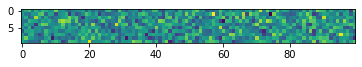

In [75]:
plt.imshow(noise)

In [78]:
images = generator(noise)

In [79]:
images.shape

TensorShape([10, 28, 28, 1])

In [81]:
single_image = images[0]

In [83]:
# single_image.numpy().reshape(28,28)
single_image.shape

TensorShape([28, 28, 1])

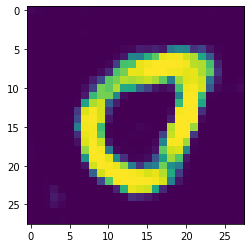

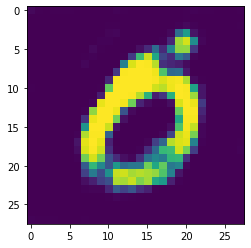

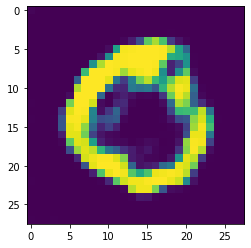

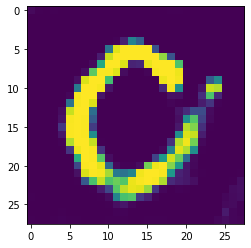

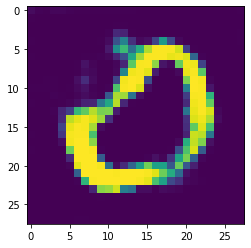

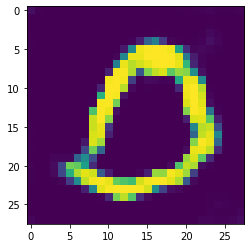

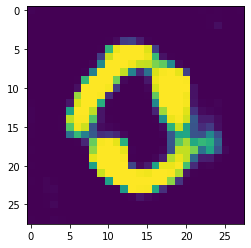

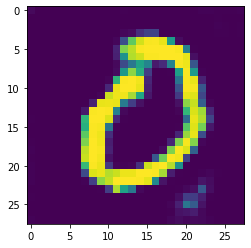

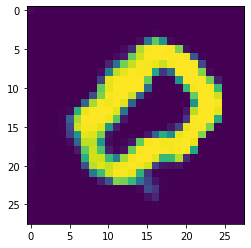

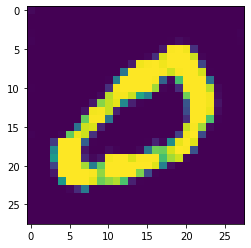

In [84]:
for image in images:
    plt.imshow(image.numpy().reshape(28, 28))
    plt.show()

In [ ]:
#as we can see above, now that we have used "DCGAN", the generator does not collapse and produces a distinctive image in each epoch.